In [ ]:
import h5py
import numpy as np

with h5py.File("C:/Users/rytme/OneDrive/Documentos/Data/2024-05-01 M2 AMMTO Fatigue Blanks 05.hdf5", 'r') as f:

    print("Keys in the file:", list(f.keys()))

    # print("\nFull file structure:")
    # def print_all_paths(name):
    #     print(name)
    
    # f.visit(print_all_paths)

    try:
        dataset = f['slices/registered_data/x-ray_ct_data']

        print("Full dataset shape:", dataset.shape)
        print("Full dataset type:", dataset.dtype)

        my_data = dataset[0]
        print("\nData shape:", my_data.shape)
        print("Data type:", my_data.dtype)
        print("First 5 values:", my_data[:5])

    except KeyError as e:
        print(f"\nStill got an error: {e}")
        print("Please check the 'Full file structure' output above to find the correct path for your data.")

Keys in the file: ['parts', 'points', 'reference_images', 'scans', 'slices', 'temporal']
Full dataset shape: (1117, 13752, 13752)
Full dataset type: uint16

Data shape: (13752, 13752)
Data type: uint16
First 5 values: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## TODO:
A lot to do here


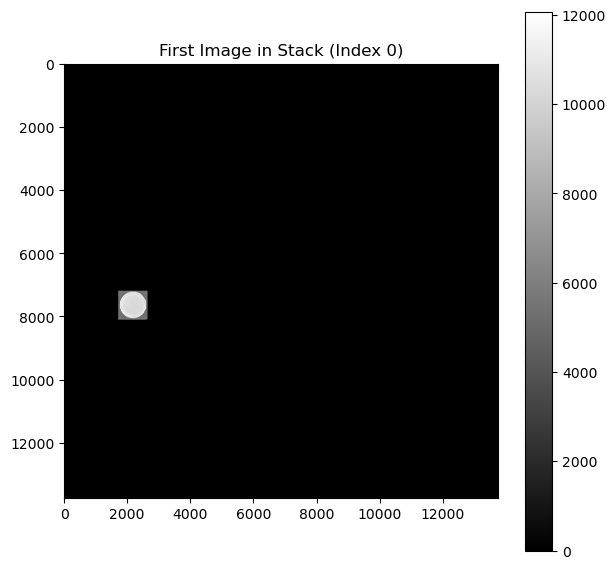

In [ ]:
import matplotlib.pyplot as plt

coords = np.argwhere(my_data > 0)

# 2. Find the bounding box (min/max coordinates)
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

# 3. Slice the original image to create the cropped version
# Note: +1 on the max bounds because slicing is exclusive
cropped_data = my_data[y_min:y_max+1, x_min:x_max+1]

# 4. Display the result
plt.figure(figsize=(7, 7))
plt.imshow(cropped_data, cmap='gray') 
plt.title("Cropped to Actual Image Data")
plt.colorbar()
plt.show()

In [ ]:
import simplnx as nx
import h5py
import numpy as np
import os

def convert_hdf5_to_dream3d(input_file, output_file, all_dataset_paths):
    """
    Reads all datasets from an HDF5 file and saves them into a new
    .dream3d file, creating ImageGeometries for image-like data.
    """
    
    DTYPE_MAP = {
        np.dtype('int8'): nx.NumericType.int8,
        np.dtype('uint8'): nx.NumericType.uint8,
        np.dtype('int16'): nx.NumericType.int16,
        np.dtype('uint16'): nx.NumericType.uint16,
        np.dtype('int32'): nx.NumericType.int32,
        np.dtype('uint32'): nx.NumericType.uint32,
        np.dtype('int64'): nx.NumericType.int64,
        np.dtype('uint64'): nx.NumericType.uint64,
        np.dtype('float32'): nx.NumericType.float32,
        np.dtype('float64'): nx.NumericType.float64,
        # np.dtype('bool'): nx.NumericType.boolean,
    }
    
    image_dataset_paths = []
    generic_dataset_paths = []
    
    for path in all_dataset_paths:
        if 'camera_data' in path or 'registered_data' in path or 'segmentation_results' in path:
            image_dataset_paths.append(path)
        else:
            generic_dataset_paths.append(path)
            
    print(f"Found {len(image_dataset_paths)} image datasets and {len(generic_dataset_paths)} generic datasets.")

    print("Creating new simplnx DataStructure...")
    data_structure = nx.DataStructure()

    print("Finding all parent groups...")
    all_parent_groups = set()
    for path_str in all_dataset_paths:
        parts = path_str.split('/')
        # For generic data, we only need the parent (e.g., 'slices')
        # For image data, the dataset name itself (e.g., '0') becomes a DataGroup
        # to hold the 'Image Geometry'
        limit = len(parts)
        if path_str in generic_dataset_paths:
            limit = len(parts) - 1 # Stop at the parent
            
        for i in range(1, limit + 1):
            parent_path = '/'.join(parts[:i])
            all_parent_groups.add(parent_path)
    
    sorted_groups = sorted(list(all_parent_groups))
    
    print(f"Creating {len(sorted_groups)} parent groups...")
    for group_path_str in sorted_groups:
        nx_group_path = nx.DataPath(group_path_str.split('/'))
        group_result = nx.CreateDataGroupFilter.execute(
            data_structure=data_structure,
            data_object_path=nx_group_path
        )
        if len(group_result.errors) != 0:
             print(f"    WARNING creating group '{group_path_str}': {group_result.errors}")
    print("All parent groups created.")

    try:
        with h5py.File(input_file, 'r') as f_in:
            for path_str in image_dataset_paths:
                print(f"  Processing: {path_str}")
                
                numpy_data = f_in[path_str][:]
                nx_path_parts = path_str.split('/')
                
                if numpy_data.dtype not in DTYPE_MAP:
                    print(f"    WARNING: Skipping. Unsupported dtype: {numpy_data.dtype}")
                    continue
                nx_dtype = DTYPE_MAP[numpy_data.dtype]
                
                # simplnx dims are [X, Y, Z]
                # numpy shape is (Z, Y, X) or (Y, X)
                if numpy_data.ndim == 3: # 3D Stack (Z, Y, X)
                    shape_zyx = numpy_data.shape
                    dims_xyz = [shape_zyx[2], shape_zyx[1], shape_zyx[0]]
                    tuple_dims = [list(shape_zyx)]
                elif numpy_data.ndim == 2: # 2D Image (Y, X)
                    shape_yx = numpy_data.shape
                    dims_xyz = [shape_yx[1], shape_yx[0], 1]
                    tuple_dims = [list(shape_yx)]
                else:
                    print(f"    WARNING: Skipping. Data is not 2D or 3D (shape: {numpy_data.shape}).")
                    continue
                
                geom_name = "Image Geometry"
                cell_data_name = "Cell Data"
                pixel_data_name = "Pixel Data"
                
                geom_path = nx.DataPath(nx_path_parts + [geom_name])
                # This is the path to the data array *inside* the geometry
                pixel_data_path = nx.DataPath(nx_path_parts + [geom_name, cell_data_name, pixel_data_name])
                
                result_geom = nx.CreateGeometryFilter.execute(
                    data_structure=data_structure,
                    output_geometry_path=geom_path,
                    geometry_type_index=0,  # 0 = Image Geometry
                    dimensions=dims_xyz,
                    origin=[0.0, 0.0, 0.0],
                    spacing=[1.0, 1.0, 1.0],
                    cell_attribute_matrix_name=cell_data_name
                )
                if len(result_geom.errors) != 0:
                    print(f"    ERROR creating geometry: {result_geom.errors}")
                    continue
                    
                result_arr = nx.CreateDataArrayFilter.execute(
                    data_structure=data_structure,
                    numeric_type_index=nx_dtype,
                    component_count=1,
                    tuple_dimensions=tuple_dims,
                    output_array_path=pixel_data_path, # Use the new, nested path
                    initialization_value_str="0"
                )
                if len(result_arr.errors) != 0:
                    print(f"    ERROR creating array: {result_arr.errors}")
                    continue
                
                np_view = data_structure[pixel_data_path].store.npview()
                np_view = np.squeeze(np_view)

                np_view[:] = numpy_data
                print(f"    ...Created Image Geometry with {dims_xyz} dims.")

            print("\nProcessing Generic DataArrays...")
            for path_str in generic_dataset_paths:
                print(f"  Processing: {path_str}")
                numpy_data = f_in[path_str][:]
                nx_path = nx.DataPath(path_str.split('/'))
                
                if numpy_data.dtype not in DTYPE_MAP:
                    print(f"    WARNING: Skipping. Unsupported dtype: {numpy_data.dtype}")
                    continue
                nx_dtype = DTYPE_MAP[numpy_data.dtype]
                
                result = nx.CreateDataArrayFilter.execute(
                    data_structure=data_structure,
                    numeric_type_index=nx_dtype,
                    component_count=1,
                    tuple_dimensions=[list(numpy_data.shape)],
                    output_data_array=nx_path,
                    initialization_value="0"
                )
                if len(result.errors) != 0:
                    print(f"    ERROR creating array: {result.errors}")
                    continue
                
                np_view = data_structure[nx_path].store.npview()
                np_view = np.squeeze(np_view)

                np_view[:] = numpy_data
                print(f"    ...Copied {numpy_data.shape} array.")

        print(f"\nWriting to .dream3d file: {output_file}")
        write_result = nx.WriteDREAM3DFilter.execute(
            data_structure=data_structure,
            export_file_path=output_file,
            write_xdmf_file=True
        )
        
        if len(write_result.errors) != 0:
            print(f"FATAL ERROR saving file: {write_result.errors}")
        else:
            print("---")
            print("Successfully converted HDF5 to .dream3d!")
            print(f"Output file: {output_file}")
            print("---")

    except FileNotFoundError:
        print(f"FATAL ERROR: Input file not found at {input_file}")
    except KeyError as e:
        print(f"FATAL ERROR: Path not found in HDF5 file. {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Your File Information ---
input_hdf5_path = 'C:/Users/rytme/Downloads/2024-05-01 M2 AMMTO Fatigue Blanks 05.hdf5'
output_dream3d_path = 'C:/Users/rytme/Downloads/My_Converted_Data_Geom.dream3d' # Changed output name

# The full list of datasets to copy
all_dataset_paths = [
    'slices/camera_data/nir/0',
    # 'slices/camera_data/nir/1', 'slices/camera_data/nir/2',
    'slices/camera_data/visible/0', 
    # 'slices/camera_data/visible/1',
    # 'slices/part_ids',
    # 'slices/registered_data/x-ray_ct_data', 'slices/registered_data/x-ray_ct_flaw',
    # 'slices/sample_ids',
    # 'slices/segmentation_results/0', 'slices/segmentation_results/1', 'slices/segmentation_results/10',
    # 'slices/segmentation_results/11', 'slices/segmentation_results/12', 'slices/segmentation_results/13',
    # 'slices/segmentation_results/14', 'slices/segmentation_results/15', 'slices/segmentation_results/16',
    # 'slices/segmentation_results/17', 'slices/segmentation_results/2', 'slices/segmentation_results/3',
    # 'slices/segmentation_results/4', 'slices/segmentation_results/5', 'slices/segmentation_results/6',
    # 'slices/segmentation_results/7', 'slices/segmentation_results/8', 'slices/segmentation_results/9'
]

# --- Run the Conversion ---
if __name__ == "__main__":
    convert_hdf5_to_dream3d(input_hdf5_path, output_dream3d_path, all_dataset_paths)

Found 2 image datasets and 0 generic datasets.
Creating new simplnx DataStructure...
Finding all parent groups...
Creating 6 parent groups...
All parent groups created.
Successfully opened HDF5 file: C:/Users/rytme/Downloads/2024-05-01 M2 AMMTO Fatigue Blanks 05.hdf5

Processing Image Geometries...
  Processing: slices/camera_data/nir/0
    ...Created Image Geometry with [2844, 2844, 1117] dims.
  Processing: slices/camera_data/visible/0
    ...Created Image Geometry with [2844, 2844, 1117] dims.

Processing Generic DataArrays...

Writing to .dream3d file: C:/Users/rytme/Downloads/My_Converted_Data_Geom.dream3d
---
Successfully converted HDF5 to .dream3d!
Output file: C:/Users/rytme/Downloads/My_Converted_Data_Geom.dream3d
---
